# Function Defined in process.py, crawl.py, graph.py
Follow the flow in flow.txt

In [1]:
from datasets import load_dataset

g:\Miniconda3\envs\rag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import re
import unicodedata
from bs4 import BeautifulSoup, Tag, Comment
import json
import os
import numpy as np
import requests
from hdbscan import HDBSCAN
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List, Tuple, Dict
import networkx as nx
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import dotenv
from groq import Groq

## Process HTML

In [3]:
class BlockNode:
    def __init__(self, tag, attributes=None, content=None):
        self.tag = tag
        self.path = []
        self.attributes = attributes or {}
        self.content = content.strip() if content else ""
        self.children = []
        self.block = ""
        self.is_leaf = False
        self.embedding = None

        # Clustering metadata
        self.cluster_label = None  # e.g., -1 for outliers
        self.cluster_prob = None   # Optional: HDBSCAN probability
        self.cluster_strength = None  # Optional: e.g., stability or outlier_score

    def add_child(self, child):
        self.children.append(child)

    def to_dict(self):
        return {
            "tag": self.tag,
            "attributes": self.attributes,
            "content": self.content,
            "children": [child.to_dict() for child in self.children],
            "cluster_label": self.cluster_label,
            "cluster_prob": self.cluster_prob,
            "cluster_strength": self.cluster_strength,
        }

    def __str__(self):
        return (
            f"Tag: {self.tag}, Content: {self.content}, "
            f"Children: {len(self.children)}, Cluster: {self.cluster_label}"
        )

    def __repr__(self):
        return (
            f"<BlockNode tag={self.tag} "
            f"block={self.block!r} "
            f"length={len(self.block.split())} {len(self.content.split())} "
            f"path={self.path} "
            f"children={len(self.children)} "
            f"cluster={self.cluster_label}>"
        )


In [4]:
def clean_html(html_content: str) -> BeautifulSoup:
    soup = BeautifulSoup(html_content, "html.parser")

    # Remove <script>, <style>, and comments
    for tag in soup(["script", "style"]):
        tag.decompose()
    for comment in soup.find_all(string=lambda t: isinstance(t, Comment)):
        comment.extract()

    # Clean attributes (remove inline styles, overly long values)
    for tag in soup.find_all(True):
        for attr in list(tag.attrs.keys()):
            if attr == "style" or len(str(tag[attr])) > 50:
                del tag[attr]

    # Merge single-nested identical tags
    def merge_single_nested_tags(tag):
        while (
            len(tag.contents) == 1
            and isinstance(tag.contents[0], Tag)
            and tag.contents[0].name == tag.name
        ):
            child = tag.contents[0]
            for k, v in child.attrs.items():
                if k not in tag.attrs:
                    tag.attrs[k] = v
            child.unwrap()
        for child in tag.find_all(recursive=False):
            merge_single_nested_tags(child)

    for tag in soup.find_all(True):
        merge_single_nested_tags(tag)

    # Normalize and clean text content
    def normalize_text(text: str) -> str:
        text = text.replace("\xa0", " ")
        text = re.sub(r"xa0\d*", " ", text)
        text = re.sub(r"\s+", " ", text)
        return unicodedata.normalize("NFKC", text).strip()

    for text_node in soup.find_all(string=True):
        if isinstance(text_node, str):
            cleaned = normalize_text(text_node)
            if cleaned:
                text_node.replace_with(cleaned)
            else:
                text_node.extract()

    # Remove empty tags
    def remove_empty_tags(tag):
        for child in tag.find_all(recursive=False):
            remove_empty_tags(child)
        if not tag.contents or all(
            str(c).strip() in ["", "None"] for c in tag.contents
        ):
            tag.decompose()

    remove_empty_tags(soup)

    return soup


def build_dom_tree(html_content: BeautifulSoup) -> BlockNode:
    def build_tree(element):
        if not getattr(element, "name", None):
            return None

        # FIX: Collect only direct text children (same as original)
        direct_text = []
        for child in element.children:
            if isinstance(child, str):
                text = child.strip()
                if text:
                    direct_text.append(text)

        # ✨ Construct node first
        node = BlockNode(
            tag=element.name, attributes=element.attrs, content=" ".join(direct_text)
        )
        # Recursively build child nodes
        for child in element.children:
            child_node = build_tree(child)
            if child_node:
                node.add_child(child_node)

        if not node.content.strip() and not node.children:
            return None
        
        return node

    def losen_structure(node):
        if not node:
            return
        for child in node.children:
            losen_structure(child)
        i = 0
        while i < len(node.children):
            child = node.children[i]
            if not child.content.strip() and len(child.children) == 1:
                node.children[i] = child.children[0]
            else:
                i += 1

    root = build_tree(html_content)
    losen_structure(root)
    return root

def build_block_tree(dom_tree: BlockNode, max_window_tokens: int) -> List[BlockNode]:
    final_blocks: List[BlockNode] = []

    def safe_token_count(text: str) -> int:
        # return int(len((text or "").split()) * 0.7)
        return max(0, (len((text or "").split()) - 20) // 1.25)

    def split_text_blocks(text: str, max_tokens: int) -> List[List[BlockNode]]:
        """Split a list of BlockNodes into groups, each with <= max_tokens."""
        words = text.split()
        result = []
        current_group = []

        for word in words:
            current_group.append(word)
            if len(current_group) >= max_tokens:
                result.append(" ".join(current_group))
                current_group = []

        if current_group:
            result.append(" ".join(current_group))

        return result

    def process(node: BlockNode):
        ### traverse bottom
        # merge leaf nodes 
        # merge siblings nodes
        # if siblings merged nodes are enough save it to the final blocks
        # if not enough split it then store to the final blocks
        # cut children, travers up.
        if not node:
            return
        
        for child in node.children:
            process(child)

        leaf_children = node.children[:]
        for child in node.children:
            if not child.children:
                continue
            else:
                print("ERROR BUGs OCCUR")
                print(node.content, node.block)
                print(child.content, child.block)

        if not leaf_children:
            return

        for leaf in leaf_children:
            if not leaf.block:
                leaf.block = leaf.content or ""
        if node.block.strip() or node.content.strip():
            print(node.block, node.content, end=" ")
        merged_text = " ".join(child.block for child in leaf_children)

        total_tokens = safe_token_count(merged_text)

        if total_tokens > max_window_tokens:
            # Content too large — must split and finalize here
            for idx, chunk in enumerate(split_text_blocks(merged_text, max_window_tokens)):
                split_node = BlockNode(
                    tag=f"{node.tag}_split_{idx}",
                    content="",  # no content carried
                )
                split_node.block = chunk
                split_node.children = []
                split_node.is_leaf = True
                split_node._is_merged_leaf = True
                split_node.path = node.path[:]
                final_blocks.append(split_node)

            # Do not promote this node — its children were split and finalized
            node.children = []
            node.block = None
            return

        # Otherwise, merged block is still valid
        node.block = (node.content or "") + merged_text
        node.children = []  # critical: consumed children
        node.is_leaf = True
        node._is_merged_leaf = True
        

    def merge_upward(node: BlockNode) -> bool:
        if not node:
            return True

        node.block = node.content or ""

        # Leaf node
        if not node.children:
            node.is_leaf = True
            node._is_merged_leaf = True
            final_blocks.append(node)
            return True

        # Recursively evaluate all children
        for child in node.children:
            merge_upward(child)

        # Check if all children are merged-leaves or raw leaves
        all_leaf = all(
            getattr(child, "_is_merged_leaf", False) or not child.children
            for child in node.children
        )

        # Collapse linear branch
        if not all_leaf and len(node.children) == 1:
            child = node.children[0]
            node.block = f"{node.content or ''} {child.block or child.content or ''}".strip()
            node.children = child.children
            return False

        # Try merging if all children are merged-leaves
        if all_leaf:
            merged_texts = []
            for child in node.children:
                if child.block:
                    merged_texts.append(child.block.strip())

            total_tokens = safe_token_count(node.content) + sum(
                safe_token_count(txt) for txt in merged_texts
            )

            if total_tokens <= max_window_tokens:
                node.block = (node.content or "").strip()
                if merged_texts:
                    if node.block:
                        node.block += " " + " ".join(merged_texts)
                    else:
                        node.block = " ".join(merged_texts)
                node.children = []
                node.is_leaf = True
                node._is_merged_leaf = True
                final_blocks.append(node)
                return True

        # Cannot merge
        node.block = node.block or node.content or ""
        node.is_leaf = False
        node._is_merged_leaf = False
        return False


    def retag_tree(node: BlockNode, tag_counts=None):
        tag_counts = tag_counts or {}
        tag_prefix = "".join(filter(str.isalpha, node.tag)) or "node"
        tag_counts[tag_prefix] = tag_counts.get(tag_prefix, 0) + 1
        node.tag = f"{tag_prefix}{tag_counts[tag_prefix]}"
        node.path = node.path + [node.tag]
        for child in node.children:
            child.path = node.path.copy()
            retag_tree(child, tag_counts)

    if dom_tree.tag == "[document]":
        dom_tree.tag = "document"

    retag_tree(dom_tree)
    # merge_upward(dom_tree)
    process(dom_tree)
    return final_blocks

def fetch_embedding(text_or_texts: str | list[str]) -> list[dict] | None:
    # EMB_MODEL_ID = "text-embedding-mxbai-embed-large-v1"s
    # EMB_MODEL_ID = "text-embedding-qwen3-embedding-0.6b"
    EMB_MODEL_ID = "text-embedding-nomic-embed-text-v1.5"
    """Fetch embedding for a given text from LMStudio."""
    try:
        url = "http://localhost:1234/v1/embeddings"
        data = {"model": EMB_MODEL_ID, "input": text_or_texts}
        headers = {"Content-Type": "application/json"}
        response = requests.post(url, headers=headers, data=json.dumps(data))
        # print(response)
        if response.status_code == 200:
            # print(response.json())
            return response.json()["data"]
        else:
            print(f"[Embedding API Error {response.status_code}] {response.text}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error querying LMStudio for Embedding: {e}")
        return None


def extract_block_texts(blocks: List[BlockNode]) -> List[str]:
    """Extract non-empty block content from a flat list of final BlockNodes."""
    return [b.block.strip() for b in blocks if b.block and b.block.strip()]

def embed_block_contents(blocks: list[BlockNode], block_contents: list[str]) -> None:
    """Embed a list of block texts and assign to the corresponding BlockNodes."""
    batch_size = 100
    all_embeddings = []

    for i in range(0, len(block_contents), batch_size):
        contents_batch = block_contents[i : i + batch_size]
        batch_embeddings = fetch_embedding(contents_batch)
        if batch_embeddings is None:
            raise RuntimeError(f"Embedding failed for batch {i}-{i + batch_size}")
        all_embeddings.extend(batch_embeddings)

    expected = len([c for c in block_contents if c.strip()])
    if len(all_embeddings) != expected:
        raise ValueError(f"Expected {expected} embeddings, got {len(all_embeddings)}")

    emb_idx = 0
    for block in blocks:
        if block.block and block.block.strip():
            block.embedding = all_embeddings[emb_idx]["embedding"]
            emb_idx += 1

def embed_block_nodes(blocks: list[BlockNode]) -> None:
    """Embed block content of each BlockNode directly, assuming pre-cleaned and tokenized."""
    batch_size = 16
    all_embeddings = []

    valid_blocks = [blk for blk in blocks if blk.block and blk.block.strip()]
    valid_contents = [blk.block for blk in valid_blocks]

    for i in range(0, len(valid_contents), batch_size):
        contents_batch = valid_contents[i : i + batch_size]
        batch_embeddings = fetch_embedding(contents_batch)
        if batch_embeddings is None:
            raise RuntimeError(f"Embedding failed for batch {i}-{i + batch_size}")
        all_embeddings.extend(batch_embeddings)

    if len(all_embeddings) != len(valid_blocks):
        raise ValueError(f"Expected {len(valid_blocks)} embeddings, got {len(all_embeddings)}")

    for blk, emb in zip(valid_blocks, all_embeddings):
        blk.embedding = emb["embedding"]
def collect_leaf_blocks(node: BlockNode) -> list[BlockNode]:
    """Recursively collect all leaf BlockNodes that contain embeddings."""
    if node.is_leaf and node.embedding is not None:
        return [node]
    blocks = []
    for child in node.children:
        blocks.extend(collect_leaf_blocks(child))
    return blocks


def cluster_block_embeddings(blocks: List[BlockNode], min_cluster_size: int = 2) -> None:
    """
    Cluster leaf blocks of the BlockNode tree using HDBSCAN.

    Adds cluster metadata to each leaf node:
    - node.cluster_label: int, -1 for noise
    - node.cluster_prob: float, confidence of assignment
    - node.cluster_strength: float, outlier score (lower is more stable)
    """
    embedded_blocks = [b for b in blocks if b.embedding is not None]
    if not embedded_blocks:
        print("[Clustering skipped] No embedded blocks.")
        return

    embeddings = np.array([b.embedding for b in embedded_blocks])
    if len(embeddings) < min_cluster_size:
        print(
            f"[Clustering skipped] Not enough points to cluster (found {len(embeddings)})."
        )
        return
    print(min_cluster_size)
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size, prediction_data=True)
    labels = clusterer.fit_predict(embeddings)
    probs = clusterer.probabilities_
    strengths = clusterer.outlier_scores_

    for b, label, prob, strength in zip(embedded_blocks, labels, probs, strengths):
        b.cluster_label = int(label)
        b.cluster_prob = float(prob)
        b.cluster_strength = float(strength)

    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"[Clustering complete] {num_clusters} clusters formed")
    


def prune_blocks_by_cluster(
    blocks: List[BlockNode], max_link: int, min_threshold: int = 2
) -> List[BlockNode]:
    """
    Prune blocks based on clustering of embeddings.
    """
    pass


def cluster_and_prune_blocks(
    blocks: List[BlockNode], max_link: int, min_threshold: int = 2, min_cluster_size: int = 2
) -> BlockNode:
    ...
    cluster_block_embeddings(blocks, min_cluster_size)
    pruned_blocks = prune_blocks_by_cluster(blocks, max_link, min_threshold)
    return pruned_blocks

In [5]:
def heuristic_function(path1, path2):
    common_prefix = 0
    for i, j in zip(path1, path2):
        if i == j:
            common_prefix += 1
        else: break
    depth1 = len(path1)
    depth2 = len(path2)
    depth_difference = abs(depth1 - depth2)
    # 3. Sibling relationship
    sibling_score = 0
    if depth1 == depth2 and path1[:-1] == path2[:-1]:
        sibling_score = 1

    # # 4. Custom tag weights
    # weight_score = 0
    # for tag in path1 + path2:
    #     weight_score += tag_weights.get(tag, 0)

    # Combine factors into a single heuristic score
    relationship_score = (
        common_prefix * 2  # Common prefix is more important
        - depth_difference * 0.5  # Penalize depth differences
        + sibling_score * 3  # Reward sibling relationship
        # + weight_score * 0.1  # Incorporate tag weights
    )

    return max(relationship_score, 0)

def compute_combined_score(
    uid_a: str,
    uid_b: str,
    sim_score: float,
    uid_to_block: Dict[str, BlockNode],
    alpha: float = 0.5,
    beta: float = 0.5,
) -> float:
    """
    Combines semantic similarity and structural similarity into a single score.

    Parameters:
        uid_a, uid_b: Node identifiers
        sim_score: Cosine similarity between their embeddings
        uid_to_block: Map from UID to BlockNode for path lookup
        alpha: Weight for semantic similarity
        beta: Weight for structural similarity

    Returns:
        Combined similarity score
    """
    path_a = uid_to_block[uid_a].path
    path_b = uid_to_block[uid_b].path
    struct_score = heuristic_function(path_a, path_b)
    return alpha * sim_score + beta * struct_score


In [6]:

def link_cluster_nodes_topk(G: nx.DiGraph, blocks: List[BlockNode], topk_ratio=0.5):
    clusters = defaultdict(list)
    uid_to_block = {}

    # Group blocks by cluster ID
    for block in blocks:
        if hasattr(block, "cluster_label"):
            uid = "_".join(block.path) + "_" + block.tag
            clusters[block.cluster_label].append(uid)
            uid_to_block[uid] = block

    for cluster_id, node_ids in clusters.items():
        if cluster_id == -1:
            print("Skip noise cluster")
            continue
        if len(node_ids) < 2:
            print("Skip trivial cluster")
            continue

        embeddings = [G.nodes[uid]["embd"] for uid in node_ids]
        sim_matrix = cosine_similarity(embeddings)
        k = max(1, int(topk_ratio * len(node_ids)))

        # Build top-k neighbors with combined score
        topk_neighbors = {}
        for i, uid_i in enumerate(node_ids):
            scored_neighbors = []
            for j, uid_j in enumerate(node_ids):
                if i == j:
                    continue
                sim_score = sim_matrix[i][j]
                score = compute_combined_score(uid_i, uid_j, sim_score, uid_to_block)
                scored_neighbors.append((score, uid_j))
            topk_neighbors[uid_i] = set(
                uid for _, uid in sorted(scored_neighbors, reverse=True)[:k]
            )

        # Add mutual top-k edges
        for i, uid_i in enumerate(node_ids):
            for j, uid_j in enumerate(node_ids):
                if i >= j:
                    continue
                if uid_j in topk_neighbors[uid_i] and uid_i in topk_neighbors[uid_j]:
                    sim_score = sim_matrix[i][j]
                    score = compute_combined_score(uid_i, uid_j, sim_score, uid_to_block)
                    G.add_edge(uid_i, uid_j, weight=score)
                    G.add_edge(uid_j, uid_i, weight=score)

        # Fallback: ensure no isolated nodes
        for i, uid_i in enumerate(node_ids):
            if G.degree(uid_i) == 0:
                best_score = -float("inf")
                best_j = None
                for j, uid_j in enumerate(node_ids):
                    if i == j:
                        continue
                    sim_score = sim_matrix[i][j]
                    score = compute_combined_score(uid_i, uid_j, sim_score, uid_to_block)
                    if score > best_score:
                        best_score = score
                        best_j = uid_j
                if best_j is not None:
                    G.add_edge(uid_i, best_j, weight=best_score)
                    G.add_edge(best_j, uid_i, weight=best_score)

def partition_blocks(blocks: List["BlockNode"]) -> Tuple[Dict[str, List], List[Tuple[str, np.ndarray]], Dict[str, "BlockNode"]]:
    cluster_map = defaultdict(list)
    noise_nodes = []
    uid_to_block = {}
    singleton_counter = 0

    for block in blocks:
        uid = "_".join(block.path) + "_" + block.tag
        label = block.cluster_label
        if label == -1:
            label = f"singleton_{singleton_counter}"
            singleton_counter += 1
            noise_nodes.append((uid, block.embedding))
        else:
            cluster_map[label].append((uid, block.embedding))
        uid_to_block[uid] = block

    return cluster_map, noise_nodes, uid_to_block


def link_cluster_to_cluster(
    G: nx.DiGraph,
    cluster_map: Dict,
    uid_to_block: Dict[str, BlockNode],
    mode: str = "topk",
    k: int = 2,
    threshold: float = 0.75
):
    cluster_ids = list(cluster_map.keys())

    for i in range(len(cluster_ids)):
        for j in range(i + 1, len(cluster_ids)):
            cluster_i = cluster_map[cluster_ids[i]]
            cluster_j = cluster_map[cluster_ids[j]]

            if not cluster_i or not cluster_j:
                continue

            uids_i, embds_i = zip(*cluster_i)
            uids_j, embds_j = zip(*cluster_j)

            sim_matrix = cosine_similarity(embds_i, embds_j)

            for idx_i, uid_i in enumerate(uids_i):
                sims = sim_matrix[idx_i]

                if mode == "topk":
                    top_indices = np.argsort(sims)[-k:]
                elif mode == "threshold":
                    top_indices = [jdx for jdx, score in enumerate(sims) if score >= threshold]
                else:
                    raise ValueError("Invalid mode")

                for jdx in top_indices:
                    uid_j = uids_j[jdx]
                    sim_score = sims[jdx]

                    if uid_i not in uid_to_block or uid_j not in uid_to_block:
                        continue  # skip if structure data is unavailable

                    combined_score = compute_combined_score(
                        uid_i, uid_j, sim_score, uid_to_block
                    )

                    G.add_edge(uid_i, uid_j, weight=combined_score)
                    G.add_edge(uid_j, uid_i, weight=combined_score)


def identify_centroids(cluster_map: Dict) -> List[Tuple[str, np.ndarray]]:
    centroids = []
    for label, members in cluster_map.items():
        if not members:
            continue
        emb_list = [emb for _, emb in members]
        centroid = np.mean(emb_list, axis=0)

        distances = cosine_similarity([centroid], emb_list)[0]
        best_idx = int(np.argmax(distances))
        representative_uid = members[best_idx][0]

        centroids.append((representative_uid, centroid))
    return centroids

def link_noise_to_centroids(
    G: nx.DiGraph,
    noise_nodes: List[Tuple[str, np.ndarray]],
    centroid_targets: List[Tuple[str, np.ndarray]],
    uid_to_block: Dict[str, BlockNode],
    noise_topk: int,
    alpha: float = 0.5,
    beta: float = 0.5,
):
    for uid_noise, emb_noise in noise_nodes:
        candidates = [(uid, emb) for uid, emb in centroid_targets if uid != uid_noise]
        if not candidates:
            continue
        target_uids, target_embs = zip(*candidates)

        sims = cosine_similarity([emb_noise], target_embs)[0]
        top_indices = np.argsort(sims)[-noise_topk:]

        for idx in top_indices:
            uid_target = target_uids[idx]
            sim_score = sims[idx]

            if uid_noise not in uid_to_block or uid_target not in uid_to_block:
                continue

            score = compute_combined_score(uid_noise, uid_target, sim_score, uid_to_block)
            G.add_edge(uid_noise, uid_target, weight=score)
            G.add_edge(uid_target, uid_noise, weight=score)

def link_remaining_noise_to_noise(
    G: nx.DiGraph,
    noise_nodes: List[Tuple[str, np.ndarray]],
    uid_to_block: Dict[str, BlockNode],
    noise_topk: int,
    alpha: float = 0.5,
    beta: float = 0.5,
):
    if not noise_nodes or len(noise_nodes) < 2:
        return

    uid_list, emb_list = zip(*noise_nodes)
    sim_matrix = cosine_similarity(emb_list, emb_list)
    degree_map = {uid: G.out_degree(uid) for uid in uid_list}

    for i, uid_i in enumerate(uid_list):
        if degree_map[uid_i] >= noise_topk:
            continue

        sim_scores = sim_matrix[i]
        sim_scores[i] = -1.0  # mask self

        sorted_indices = np.argsort(sim_scores)[::-1]

        for j in sorted_indices:
            uid_j = uid_list[j]
            if uid_i == uid_j or degree_map[uid_j] >= noise_topk or degree_map[uid_i] >= noise_topk:
                continue

            if uid_i not in uid_to_block or uid_j not in uid_to_block:
                continue

            sim_score = sim_scores[j]
            score = compute_combined_score(uid_i, uid_j, sim_score, uid_to_block)
            G.add_edge(uid_i, uid_j, weight=score)
            G.add_edge(uid_j, uid_i, weight=score)

            degree_map[uid_i] += 1
            degree_map[uid_j] += 1

def link_cross_cluster_nodes_dense(
    G: nx.DiGraph,
    blocks: List["BlockNode"],
    mode: str = "topk",
    k: int = 2,
    threshold: float = 0.75,
    noise_topk: int = 2,
):
    cluster_map, noise_nodes, uid_to_block = partition_blocks(blocks)

    # Guard: Nothing to do
    if not cluster_map and not noise_nodes:
        print("No clusters or noise found — skipping graph construction.")
        return

    cluster_count = len(cluster_map)

    # Step 1: Link cluster representatives
    if cluster_count > 1:
        link_cluster_to_cluster(G, cluster_map, uid_to_block, mode=mode, k=k, threshold=threshold)

    # Step 2: Identify cluster centroids
    centroid_targets = identify_centroids(cluster_map)

    # Step 3: Link noise to centroids (only if both noise and centroids exist)
    if noise_nodes and centroid_targets:
        try:
            link_noise_to_centroids(G, noise_nodes, centroid_targets, uid_to_block, noise_topk=noise_topk)
        except ValueError:
            print("link_noise_to_centroids failed due to unpacking error — empty centroid list?")
            pass

    # Step 4: Link remaining noise-to-noise if there are noise nodes
    if noise_nodes:
        try:
            link_remaining_noise_to_noise(G, noise_nodes, uid_to_block, noise_topk=noise_topk)
        except ValueError:
            print("link_remaining_noise_to_noise failed due to empty noise set.")
            pass

    # Step 5: Optionally link centroids (even in the absence of noise)
    if centroid_targets and len(centroid_targets) > 1:
        link_centroid_nodes(G)

def group_cluster_nodes(G: nx.DiGraph) -> Dict[int, List[Tuple[str, np.ndarray]]]:
    """Group nodes by cluster label (excluding noise)."""
    cluster_map = defaultdict(list)
    for node in G.nodes:
        label = G.nodes[node].get("cluster_label", -1)
        if label != -1:
            embd = G.nodes[node]["embd"]
            cluster_map[label].append((node, embd))
    return cluster_map

def link_centroid_nodes(G: nx.DiGraph):
    """
    Link representative centroid nodes across clusters 
    using original `identify_centroids` format:
    [(node_id, centroid_embd), ...]
    """
    # Step 1: Group clustered nodes only (excluding noise)
    cluster_map = group_cluster_nodes(G)

    # Step 2: Identify representative centroids
    centroid_tuples = identify_centroids(cluster_map)

    # Step 3: Link centroid nodes to each other
    for i, (uid1, emb1) in enumerate(centroid_tuples):
        for j in range(i + 1, len(centroid_tuples)):
            uid2, emb2 = centroid_tuples[j]
            sim = cosine_similarity([emb1], [emb2])[0][0]
            G.add_edge(uid1, uid2, weight=sim)
            G.add_edge(uid2, uid1, weight=sim)


def graph_construct(blocks: List["BlockNode"], topk_ratio=0.5):
    G = nx.DiGraph()

    # Step 1: Add nodes
    for block in blocks:
        uid = "_".join(block.path) + "_" + block.tag
        G.add_node(
            uid,
            tag=block.path[-1],
            content=block.block,
            path=block.path,
            embd=block.embedding,
            cluster_label=getattr(block, "cluster_label", -1),
        )

    # Step 2: Intra-cluster links
    link_cluster_nodes_topk(G, blocks, topk_ratio=topk_ratio)

    # Step 3: Inter-cluster node links (top-K or threshold)
    link_cross_cluster_nodes_dense(G, blocks, mode="topk", k=2)
    # # Step 4: Centroid-to-centroid links
    # link_centroid_nodes(G)

    # Step 5: Visualization
    # tags = {node: G.nodes[node].get("content", "")[:10] + "..." for node in G.nodes}
    # nx.draw(G, with_labels=True, labels=tags, pos=nx.spring_layout(G))

    plt.figure(figsize=(14, 10))

    # Layout
    pos = nx.spring_layout(G, seed=42)

    # Prepare node labels
    labels = {
        node: G.nodes[node].get("content", "")[:20]
        for node in G.nodes
    }

    # Node colors based on cluster

    cluster_labels = nx.get_node_attributes(G, "cluster_label")
    node_colors = [
        cluster_labels.get(node, -1) for node in G.nodes
    ]

    # Draw graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=800)
    nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_family="monospace")

    plt.title("Block Graph with Content Labels")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    return G

## Retrieve Functions

#### Rephrase Question

In [7]:
def rephrase_question(question: str):
    client = Groq(api_key=dotenv.get_key(dotenv.find_dotenv(), "GROQ_API"))

    try:
        prompt_system = {
            "role": "system",
            "content": (
                "You are a structured rephrasing assistant. Your task is to generate exactly *two* diverse but semantically equivalent "
                "paraphrases of a factual question, for use in embedding similarity evaluation.\n\n"
                "Output Requirements:\n"
                "- Return only a single valid JSON object with *three* keys: `paraphrase_1`, `paraphrase_2`.\n"
                "- Do *NOT* include extra text, explanations, or markdown formatting (do not use ```json).\n"
                '- All values must be in valid JSON strings.\n\n'
                "Strict Output Format:\n"
                "{\n"
                '  "paraphrase_1": "string",\n'
                '  "paraphrase_2": "string"\n'
                "}\n\n"
                "Guidelines:\n"
                "- The paraphrases must preserve the meaning of the original factual question.\n"
                "- `paraphrase_1` should be a mild rewording.\n"
                "- `paraphrase_2` should use significantly different phrasing or syntax (e.g., question form, passive voice, inversion).\n"
                "- Only valid JSON output is allowed. Any malformed JSON output is considered a failure.\n"
            ),
        }

        prompt_user = {
            "role": "user",
            "content": f'Paraphrase question:\n"{question}"',
        }
        few_shot_examples = [
            {
                "role": "user",
                "content": 'Paraphrase question:\n"What year did the Berlin Wall fall?"',
            },
            {
                "role": "assistant",
                "content": """
                    {"paraphrase_1": "In which year was the Berlin Wall taken down?","paraphrase_2": "When did the Berlin Wall come down?"}
                """,
            },
            {
                "role": "user",
                "content": 'Paraphrase question:\n"Who discovered penicillin?"',
            },
            {
                "role": "assistant",
                "content": json.dumps(
                    {
                        "paraphrase_1": "Which scientist is credited with the discovery of penicillin?",
                        "paraphrase_2": "Who is known for discovering penicillin?"
                    }
                ),
            },
        ]
        response = client.chat.completions.create(
            model="llama3-70b-8192",
            messages=[prompt_system] + few_shot_examples + [prompt_user],
            temperature=0.5,
            response_format={
                "type": "json_object",
                "json_object": {
                    "paraphrase_1": "string",
                    "paraphrase_2": "string",
                    "strict": ["paraphrase_1", "paraphrase_2"],
                },
            },
            stream=False,
        )

        result = response.choices[0].message.content
        parsed = json.loads(result)
        print(parsed)
        output = [question, parsed["paraphrase_1"], parsed["paraphrase_2"]]
        print(output)
        return output

    except Exception as e:
        print(f"Error during question paraphrasing: {e}")
        return [question]

#### Starting Points

In [12]:
def select_cluster_representatives(
    G: nx.DiGraph,
    cluster_map: dict,
    query_vec: np.ndarray,
    topk: int = 1
) -> List[Tuple[str, float]]:
    """
    Select representative nodes from each cluster by finding the closest embedding to the query vector.
    Returns a list of (uid, score) tuples.
    """
    representatives = []

    for label, nodes in cluster_map.items():
        if not nodes:
            continue
        embds = np.array([G.nodes[uid]["embd"] for uid in nodes])
        sims = cosine_similarity(embds, query_vec.reshape(1, -1)).flatten()
        # Pick the top scoring node for this cluster
        best_idx = np.argmax(sims)
        representatives.append((nodes[best_idx], sims[best_idx]))

    # Sort representatives globally by similarity
    representatives.sort(key=lambda x: x[1], reverse=True)
    return representatives[:topk]


def select_top_noise_nodes(
    G: nx.DiGraph,
    noise_nodes: List[str],
    query_vec: np.ndarray,
    topk: int = 2
) -> List[Tuple[str, float]]:
    """Select topk noise nodes by cosine similarity to the query vector."""
    if not noise_nodes:
        return []

    embds = np.array([G.nodes[uid]["embd"] for uid in noise_nodes])
    sims = cosine_similarity(embds, query_vec.reshape(1, -1)).flatten()
    scored = list(zip(noise_nodes, sims))
    scored.sort(key=lambda x: x[1], reverse=True)
    return scored[:topk]


def get_starting_nodes(
    G: nx.DiGraph,
    query_vec: np.ndarray,
    cluster_topk: int = 1,
    noise_topk: int = 2
) -> List[Tuple[str, float]]:
    """
    Main entrypoint:
    1. Identify cluster representatives
    2. Identify top noise nodes
    3. Combine and return sorted by score
    """
    cluster_map, noise_nodes, _ = partition_blocks(G)

    reps = select_cluster_representatives(G, cluster_map, query_vec, topk=cluster_topk)
    noise = select_top_noise_nodes(G, noise_nodes, query_vec, topk=noise_topk)

    combined = reps + noise
    combined.sort(key=lambda x: x[1], reverse=True)
    return combined

## Visualize Functions

In [8]:
def get_leaf_nodes(node) -> list:
    """Recursively collect all leaf nodes with embeddings."""
    if not node.children and node.embedding is not None:
        return [node]
    leaves = []
    for child in node.children:
        leaves.extend(get_leaf_nodes(child))
    return leaves


def visualize_block_clusters(
    block_list: List[BlockNode], method="umap", title="Block Cluster Visualization"
):
    if not block_list or len(block_list) < 4:
        print("Too few blocks to visualize. Need at least 4.")
        return

    embeddings = np.array([node.embedding for node in block_list])
    labels = np.array([getattr(node, "cluster_label", -1) for node in block_list])

    # Step 2: Dimensionality reduction
    if method == "umap":
        n_samples = len(embeddings)
        n_neighbors = min(40, max(2, n_samples - 2))  # at least 2, at most n-2
        reducer = UMAP(
            n_neighbors=n_neighbors,
            n_components=2,  # default
            min_dist=0.1,
            metric="cosine",
            random_state=42
        )
    else:
        raise ValueError("Unsupported method. Use 'umap' or 'tsne'.")

    try:
        reduced = reducer.fit_transform(embeddings)
    except TypeError as e:
        print("UMAP failed due to small sample size or eigen decomposition error:", e)
        return

    # Step 3: Visualization
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=reduced[:, 0],
        y=reduced[:, 1],
        hue=labels,
        palette="tab10",
        s=70,
        legend="full",
    )
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def traverse_tree(node: BlockNode, level=0):
    """Recursively traverse the tree and print node information."""
    if not node:
        return
    indent = "  " * level
    print(
        f"{indent}Tag: {node.tag}, Content Length: {len(node.content)}, Block: {len(node.block.split(" "))}, "
        f"Children: {len(node.children)}, Cluster: {node.cluster_label}"
    )
    for child in node.children:
        traverse_tree(child, level + 1)

## Execute

In [9]:
ds = load_dataset(
    "google-research-datasets/natural_questions", "dev", split="validation"
)

In [10]:
i = 1
data = ds[i]["document"]
html_doc = data["html"]
question = ds[i]["question"]["text"]

In [11]:
question_list = rephrase_question(question)

{'paraphrase_1': 'What is the total number of senators in the US Senate?', 'paraphrase_2': 'How many members make up the US Senate?'}
['how many senators are there in the us senate', 'What is the total number of senators in the US Senate?', 'How many members make up the US Senate?']


In [225]:
html_doc = sample2 = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>More Complex Example</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            margin: 20px;
        }
        .container {
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            border: 1px solid #ccc;
        }
        h1, h2 {
            color: #333;
        }
        p {
            margin-bottom: 15px;
        }
        ul {
            list-style-type: disc;
            padding-left: 20px;
        }
        a {
            color: blue;
            text-decoration: none;
        }
        a:hover {
            text-decoration: underline;
        }
        #important {
            font-weight: bold;
            color: red;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Welcome to My Website</h1>
        <p>This is a more detailed example with additional content and styling. We're exploring various HTML elements and CSS properties.</p>

        <h2>Section 1: Introduction</h2>
        <p>This section provides an overview of the topic. We'll discuss key concepts and provide context.</p>
        <ul>
            <li>
            <a>Hello world</a>
            </li>
            <li>Point 2: Another important aspect.</li>
            <li>Point 3: A supporting detail.</li>
        </ul>

        <h2>Section 2: Further Details</h2>
        <p>Here, we delve deeper into the subject matter. You can find more information and examples below.</p>
        <p id="important">This is an important paragraph with special styling.</p>
        <a href="https://www.example.com">Visit Example Website</a>

        <div>
          <h3>A Sub Section</h3>
          <p>Some more text here</p>
          <img src="dummy_image.jpg" alt="Dummy Image" width="300">
        </div>
    </div>
</body>
</html>"""

In [21]:
cleaned_html = clean_html(html_doc)
dom_tree = build_dom_tree(cleaned_html)
final_blocks = build_block_tree(dom_tree, max_window_tokens=256)

# block_texts = extract_block_texts(final_blocks)
# embed_block_contents(final_blocks, block_texts)
embed_block_nodes(final_blocks)
cluster_and_prune_blocks(final_blocks, max_link=5)
# visualize_block_clusters(final_blocks)


 Jump to: ,  needs additional citations for  Please help by . Unsourced material may be challenged and removed.  ( )  This article .  Background  Fundamentals  Experiments  ( )  Formulations  Equations  Interpretations  Advanced topics  Scientists  is the concept in that every or entity may be partly described in terms not only of particles, but also of . It expresses the inability of the concepts "particle" or "wave" to fully describe the behavior of objects. As wrote:  Through the work of , , , , and many others, current scientific theory holds that all particles also have a wave nature (and vice versa). This phenomenon has been verified not only for elementary particles, but also for compound particles like atoms and even molecules. For particles, because of their extremely short wavelengths, wave properties usually cannot be detected.  Although the use of the wave-particle duality has worked well in physics, the or has not been satisfactorily resolved; see .  Bohr regarded the "dua

g:\Miniconda3\envs\rag\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
g:\Miniconda3\envs\rag\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Skip noise cluster


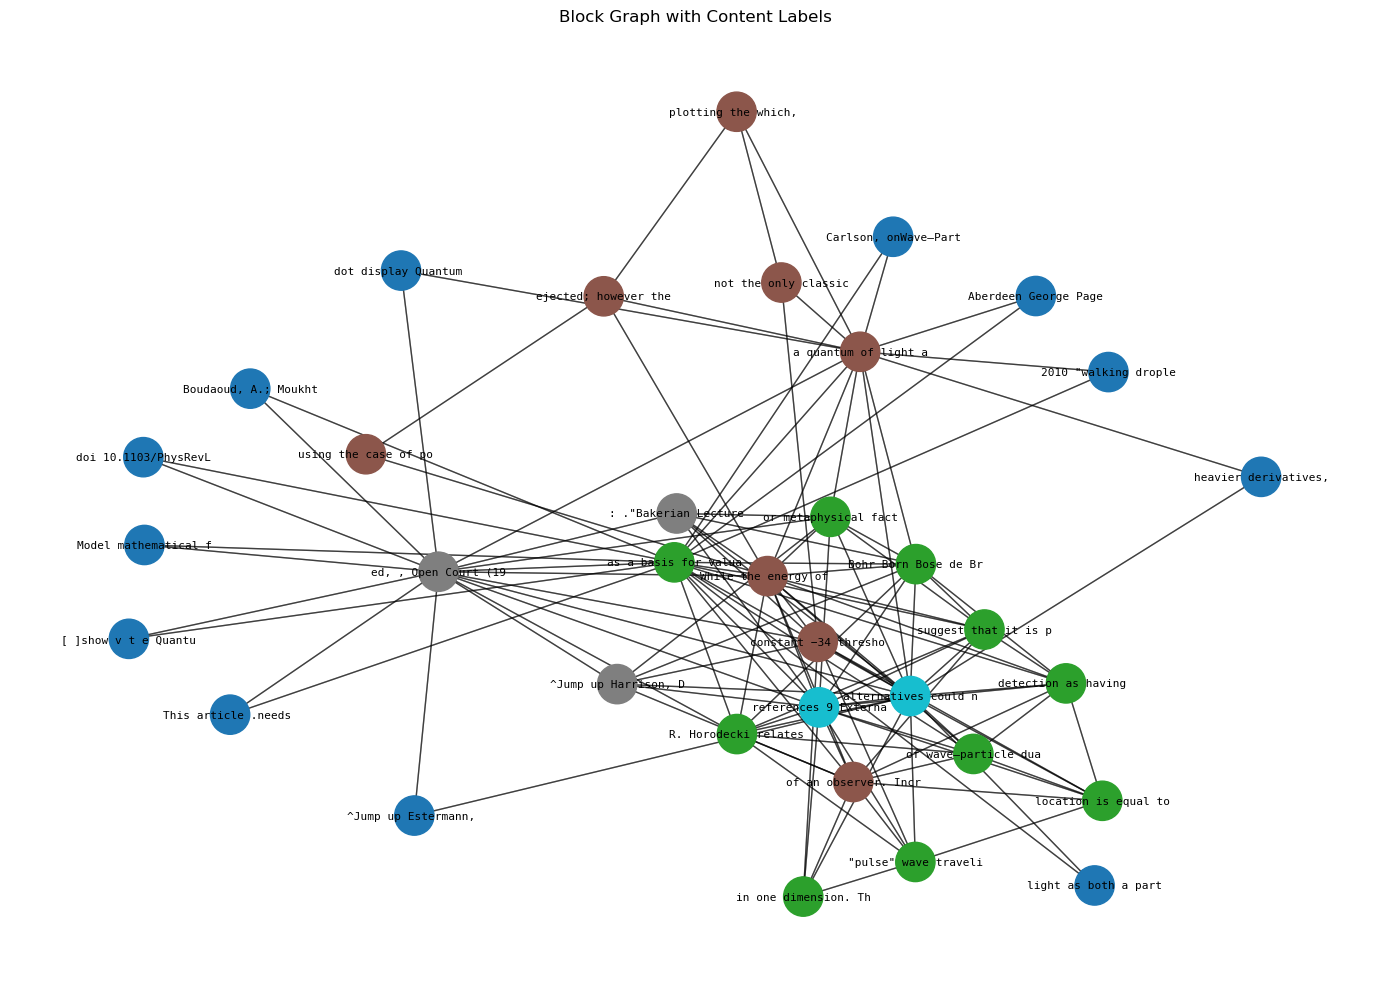

In [23]:
G = graph_construct(final_blocks)

In [12]:
len(final_blocks)

3

In [13]:
print(block_tree)

NameError: name 'block_tree' is not defined

In [14]:
visualize_block_clusters(final_blocks)


Too few blocks to visualize. Need at least 4.


In [24]:
for blk in final_blocks:
    print(blk.cluster_label, blk.cluster_prob, blk.cluster_strength)

2 1.0 0.0
2 1.0 0.0
-1 0.0 0.043122510011593326
-1 0.0 0.05471988435531917
-1 0.0 0.05471988435531917
2 1.0 0.0
-1 0.0 0.1414440276226951
-1 0.0 0.02468383573141142
-1 0.0 0.19176097616840326
-1 0.0 0.12765855205678042
0 1.0 0.0
0 0.8838145461766008 0.1161854538233992
3 1.0 0.0
3 1.0 0.0
1 0.8716368857173357 0.1283631142826643
1 0.8985309481523331 0.10146905184766683
1 0.8985309481523331 0.10146905184766683
1 1.0 0.0
1 1.0 0.0
1 1.0 0.0
1 0.9601849596923407 0.039815040307659214
1 0.8954878960251123 0.10451210397488774
-1 0.0 0.010092120975663279
0 0.8560387090902875 0.14396129090971257
-1 0.0 0.011250205834966115
-1 0.0 0.086308628913597
0 0.9765900602121558 0.023409939787844277
0 0.9258186121395169 0.07418138786048313
0 0.7985234736143054 0.20147652638569452
0 1.0 0.0
0 0.9399104835859137 0.0600895164140863
0 0.9202199037789383 0.07978009622106176
0 0.9765900602121558 0.023409939787844277
-1 0.0 0.056250596586633006
-1 0.0 0.2097421425903272
